# Plots: bar plots

In [1]:
import sys
sys.path.append("..\\source\\")
import utils as utils
import glob

# Data and numbers
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.preprocessing import MinMaxScaler

# Visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker
import matplotlib.dates as mdates
mpl.style.use('ggplot')
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

# Palettes
from matplotlib.colors import ListedColormap
from palettable.colorbrewer.qualitative import Set2_8

In [2]:
# Pallete
cmap_orig = Set2_8.mpl_colors # callable
cmap = [cmap_orig[7],cmap_orig[6],cmap_orig[4],cmap_orig[3],cmap_orig[1],cmap_orig[0]]

In [3]:
path_data = "..\\data\\processed\\summary\\"
path_meta = "..\\data\\original\\metadata\\"
path_res = "..\\results\\"
path_fig = "..\\figures\\"

In [4]:
ref = {0:"normal", 1:"A", 2:"B", 3:"C", 4:"D", 5:"E"}
color_ref = {0:cmap_orig[7], 1:cmap_orig[6], 2:cmap_orig[4], 3:cmap_orig[3], 4:cmap_orig[1], 5:cmap_orig[0]}

# Functions

In [5]:
def get_sites(path_data, path_meta, meter):
    # Load original data
    df = pd.read_pickle(path_data + f"date_vs_bdg\\{meter}_RMSLE.pickle.gz")
    # Merge with metadata
    meta_bdg = pd.read_csv(path_meta + "building_metadata.csv")
    df = pd.merge(df, meta_bdg, how="left", on="building_id")
    # List of buildings and sites
    bdgs = list(df.building_id.unique())
    sites = list(df.site_id.unique())
    print(f"sites: {len(sites)}. Buildings: {len(bdgs)}")

    return sites

In [6]:
def error_df(path_error, meter, site):

    errorD = pd.read_csv(path_res + f"{meter}_site_{site}_errorD.csv")
    df_error = errorD.copy()

    errorC = pd.read_csv(path_res + f"{meter}_site_{site}_errorC.csv")
    df_error.update(errorC)

    errorE = pd.read_csv(path_res + f"{meter}_site_{site}_errorE.csv")
    df_error.update(errorE)

    errorB = pd.read_csv(path_res + f"{meter}_site_{site}_errorB.csv")
    df_error.update(errorB)

    errorA = pd.read_csv(path_res + f"{meter}_site_{site}_errorA.csv")
    df_error.update(errorA)

    df_error = df_error.replace(["A","B","C","D","E"],[1,2,3,4,5]).fillna(0)
    df_error = df_error.apply(pd.to_numeric, errors='coerce')
    df_error.set_index("building_id",inplace=True)
    print(f"Site {site} error's dataframe created.")
    errors_type = df_error.melt().value.unique()
    
    return df_error, errors_type

# Stacked bars plots

This code returns barplots, with them overlaped (i.e., each top of bars indicates the value of that category)

In [83]:
## Create datasets
meters = ["chilledwater","electricity","hotwater","steam"]
sites = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]

errors_total_list = []
errors_type_list = []

for meter in meters:
    print(f"\nMeter {meter}")

    df_list = []

    for site in sites:
        #print(f"Site: {site}")

        try:
            df_error, error_types = error_df(path_res, meter, site)
            df_error = df_error.melt().groupby("value").count().reset_index().rename(columns={"value":"error_code","variable":"error_count"})
            df_error["site_id"] = site
            df_error["total"] = df_error.error_count.sum()
            df_list.append(df_error)

        except:
            print(f"Site not available for {meter}.")

    # Melt
    df = pd.concat(df_list)
    # Tag errors
    df["is_error"] = [0 if x == 0.0 else 1 for x in df.error_code]
    # Add pct
    df["pct"] = (df.error_count / df.total) * 100
    # Error/non-error df
    errors_total = pd.DataFrame(df.groupby(["site_id","is_error"])["pct"].sum()).reset_index()
    errors_total_list.append(errors_total)

    # Errors types df
    errors_type = df.groupby(["site_id","error_code"])["pct"].sum().reset_index()
    errors_type = errors_type[errors_type.error_code != 0]
    errors_type["error_code"] = [ref[x] for x in errors_type.error_code]
    errors_type_list.append(errors_type)

Meter chilledwater
Site not available for chilledwater.
Site not available for chilledwater.
Site 2 error's dataframe created.
Site not available for chilledwater.
Site not available for chilledwater.
Site not available for chilledwater.
Site 6 error's dataframe created.
Site 7 error's dataframe created.
Site not available for chilledwater.
Site 9 error's dataframe created.
Site 10 error's dataframe created.
Site 11 error's dataframe created.
Site not available for chilledwater.
Site 13 error's dataframe created.
Site 14 error's dataframe created.
Site 15 error's dataframe created.
Meter electricity
Site not available for electricity.
Site 1 error's dataframe created.
Site not available for electricity.
Site 3 error's dataframe created.
Site not available for electricity.
Site 5 error's dataframe created.
Site 6 error's dataframe created.
Site 7 error's dataframe created.
Site 8 error's dataframe created.
Site 9 error's dataframe created.
Site 10 error's dataframe created.
Site not ava

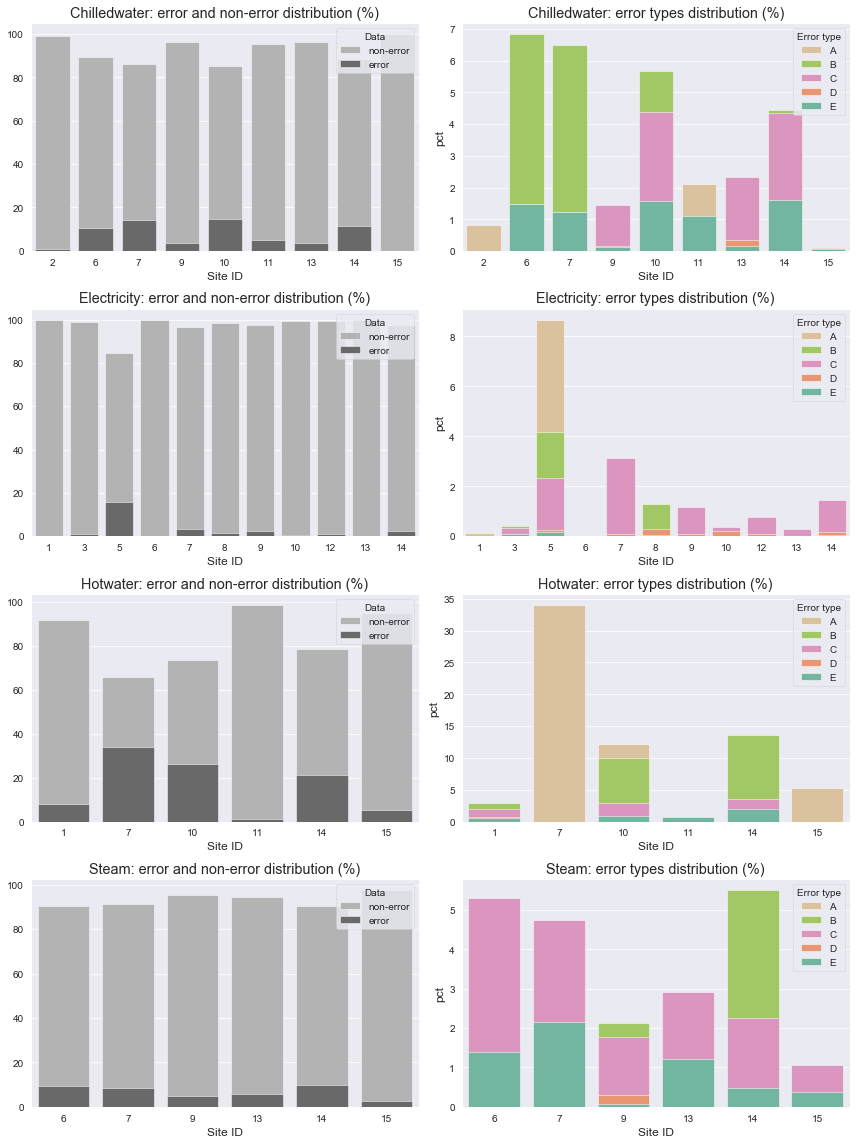

In [91]:
## Plot
meters = ["chilledwater","electricity","hotwater","steam"]
sites = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
pal1 =[cmap_orig[7],"dimgray"]
pal2 = [cmap_orig[6],cmap_orig[4],cmap_orig[3],cmap_orig[1],cmap_orig[0]]

fig, axes = plt.subplots(4, 2, sharex=False, sharey=False, figsize=(12,16))
axes = axes.flatten()

i = 0
for meter,errors_total,errors_type in zip(meters, errors_total_list, errors_type_list):
    # Plot error/non-error
    ax1 = axes[i]
    plot1 = sns.barplot(x="site_id", y="pct", hue="is_error",data=errors_total, dodge=False, ax=ax1, palette=pal1)
    ax1.set_title(f"{meter.capitalize()}: error and non-error distribution (%)")
    ax1.set_xlabel("Site ID")
    ax1.set_ylabel("")
    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles, ["non-error","error"], title="Data", loc ='upper right')

    # Plot errors type
    ax2 = axes[i+1]
    plot2 = sns.barplot(x="site_id", y="pct", hue="error_code",data=errors_type, dodge=False, ax=ax2, palette=pal2)
    ax2.set_title(f"{meter.capitalize()}: error types distribution (%)")
    ax2.set_xlabel("Site ID")
    ax2.legend(title='Error type', loc="upper right")

    i = i+2

    plt.tight_layout()

#fig.savefig(path_fig + "barplot.pdf", dpi=150, bbox_inches="tight")
#fig.savefig(path_fig + "barplot.png", dpi=150, bbox_inches="tight")

This code returns an stacked barplot (i.e., height of each bar is always 100, individual height of categories indicates value)

In [165]:
## Create datasets
meters = ["chilledwater","electricity","hotwater","steam"]
sites = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
## Load metadata
meta = pd.read_csv(path_meta + "building_metadata.csv",usecols=["building_id","site_id"])

errors_total_list = [] # this will be for plotting errror/non-error frequenci
errors_type_list = [] # this will be for plotting error types frequency
rmsle_list = [] # this will be for plottinh rmsle magnitude

for meter in meters:
    print(f"\nMETER: {meter}")

    df_list = []
    df_rmsle_list = []

    for site in sites:

        try:
            df_error, error_types = error_df(path_res, meter, site)
            # This will be used for the frequrency barplots
            df_freq = df_error.melt().groupby("value").count().reset_index().rename(columns={"value":"error_code","variable":"error_count"})
            df_freq["site_id"] = site
            df_freq["total"] = df_freq.error_count.sum()
            df_list.append(df_freq)

        except:
            print(f"Site {site} not available.")
            continue

        # This will be used for the rmsle barplot
        df_rmsle = df_error.reset_index().melt(id_vars="building_id", var_name="timestamp") # errors df
        df_rmsle.timestamp = pd.to_datetime(df_rmsle.timestamp, format="%Y-%m-%d")
        # Filter errors
        df_rmsle = df_rmsle[df_rmsle.value != 0]
        # Add site_id
        df_rmsle["site_id"] = site
        """# Load rmsle df
        df_rmsle1 = pd.read_pickle(path_data + f"date_vs_bdg\{meter}_RMSLE.pickle.gz") # rmsle df
        df_rmsle1.timestamp = pd.to_datetime(df_rmsle1.timestamp, format="%Y-%m-%d")
        # Merge both dfs to add rmsle value
        df_rmsle = pd.merge(df_rmsle, df_rmsle1, how="left", on=["building_id","timestamp"])"""
        # Add to list
        df_rmsle_list.append(df_rmsle)

    # Create frequency dfs
    df = pd.concat(df_list)
    # Tag errors
    df["is_error"] = [0 if x == 0.0 else 1 for x in df.error_code]
    # Add pct
    df["pct"] = (df.error_count / df.total) * 100

    # Error/non-error df
    errors_total = pd.DataFrame(df.groupby(["site_id","is_error"])["pct"].sum()).reset_index()
    # Correct format for stacked plot
    errors_total = errors_total.pivot(columns="is_error",values="pct",index="site_id")
    errors_total = errors_total.sort_values(1,ascending=True)
    errors_total_list.append(errors_total)

    # Errors types df
    errors_type = df.groupby(["site_id","error_code"])["pct"].sum().reset_index()
    errors_type = errors_type[errors_type.error_code != 0]
    errors_type["error_code"] = [ref[x] for x in errors_type.error_code]
    # Correct format for stacked plot
    errors_type = errors_type.pivot(columns="error_code",values="pct",index="site_id")
    errors_type = errors_type.reindex(errors_total.index)
    errors_type_list.append(errors_type)
    # Error percentage as total
    errors_type["total"] = errors_total[1]
    for col in errors_type.columns[:-1]:
        errors_type[col] = errors_type[col]/errors_type["total"]
    errors_type.drop("total",axis=1, inplace=True)

    # Creates rmsle df
    errors = pd.concat(df_rmsle_list)
    errors.timestamp = pd.to_datetime(errors.timestamp, format="%Y-%m-%d")
    errors.rename(columns={"value":"error"},inplace=True)
    ## Load RMSLE dataframe
    df1 = pd.read_pickle(path_data + f"date_vs_bdg\\{meter}_RMSLE.pickle.gz")
    df1.timestamp = pd.to_datetime(df1.timestamp, format="%Y-%m-%d")
    ## Add site_id
    df1 = pd.merge(df1,meta,how="left",on="building_id")
    ## Calculate total RMSLE error per building
    rmsle_total = pd.DataFrame(df1.groupby("site_id")["rmsle"].sum()).rename(columns={"rmsle":"rmsle_total"})
    ## Merge
    rmsle = pd.merge(errors, df1, how="left", on=["building_id","site_id","timestamp"])#on=["building_id","site_id","timestamp"]
    ## Sums RMSLE metric for each error type in site
    sums = pd.DataFrame(rmsle.groupby(["site_id","error"])["rmsle"].sum()).reset_index()
    # Replace error name
    sums["error"] = [ref[x] for x in sums.error]
    # Format for stacked barplot (percentage distribution)
    sums = sums.pivot(index="site_id",values="rmsle",columns="error")
    #sums["error_total"] = list(sums.sum(axis=1))
    sums = pd.merge(sums, rmsle_total, how = "left", on="site_id")
    for col in sums.columns[:-1]:
        sums[col] = sums[col]/sums["rmsle_total"]#sums[col] = sums[col]/sums["total"] # sums[col] = sums[col]/sums["error_total"]
    sums["non-error"] = 1 - (sums[["A","B","C","D","E"]].sum(axis=1))
    sums.drop(["rmsle_total"],axis=1, inplace=True) # sums.drop("rmsle_total",axis=1, inplace=True)
    sums = sums.reindex(errors_total.index)
    rmsle_list.append(sums)
    #del(errors,df,rmsle)


METER: chilledwater
Site 0 not available.
Site 1 not available.
Site 2 error's dataframe created.
Site 3 not available.
Site 4 not available.
Site 5 not available.
Site 6 error's dataframe created.
Site 7 error's dataframe created.
Site 8 not available.
Site 9 error's dataframe created.
Site 10 error's dataframe created.
Site 11 error's dataframe created.
Site 12 not available.
Site 13 error's dataframe created.
Site 14 error's dataframe created.
Site 15 error's dataframe created.

METER: electricity
Site 0 not available.
Site 1 error's dataframe created.
Site 2 not available.
Site 3 error's dataframe created.
Site 4 not available.
Site 5 error's dataframe created.
Site 6 error's dataframe created.
Site 7 error's dataframe created.
Site 8 error's dataframe created.
Site 9 error's dataframe created.
Site 10 error's dataframe created.
Site 11 not available.
Site 12 error's dataframe created.
Site 13 error's dataframe created.
Site 14 error's dataframe created.
Site 15 not available.

ME

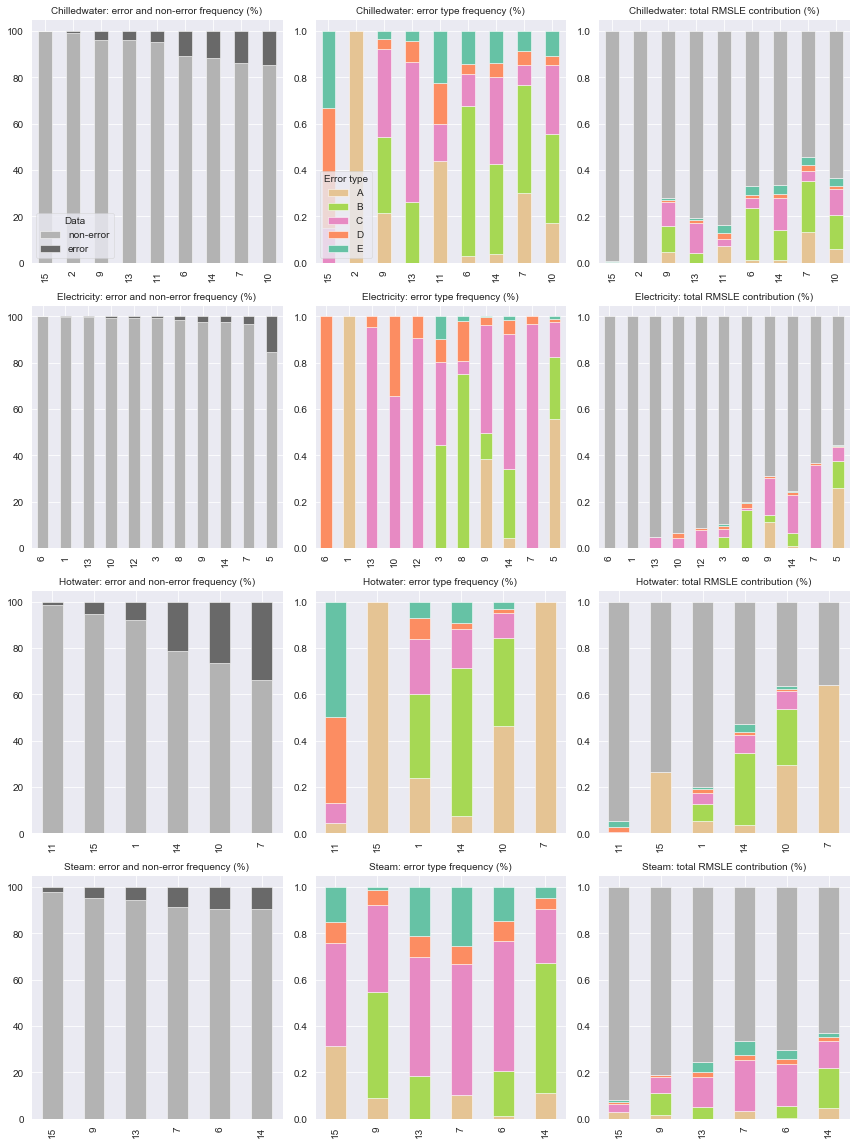

In [166]:
## Plot
meters = ["chilledwater","electricity","hotwater","steam"]
sites = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
pal1 =[cmap_orig[7],"dimgray"]
pal2 = [cmap_orig[6],cmap_orig[4],cmap_orig[3],cmap_orig[1],cmap_orig[0]]
pal3 = [cmap_orig[6],cmap_orig[4],cmap_orig[3],cmap_orig[1],cmap_orig[0],cmap_orig[7]]

fig, axes = plt.subplots(4, 3, sharex=False, sharey=False, figsize=(12,16))
axes = axes.flatten()

i=0
for meter,errors_total,errors_type,rmsle in zip(meters, errors_total_list, errors_type_list, rmsle_list):

    # Plot error/non-error
    ax1 = axes[i]
    plot1 = errors_total.plot(kind='bar', stacked=True, color=pal1, ax=ax1, width=0.5, legend=False)
    ax1.set_title(f"{meter.capitalize()}: error and non-error frequency (%)", fontsize=10)
    ax1.set_xlabel("")
    ax1.set_ylabel("")
    handles, labels = ax1.get_legend_handles_labels()
    #ax1.legend(handles, ["non-error","error"], title="Data", loc ='lower left')

    # Plot errors type
    ax2 = axes[i+1]
    plot2 = errors_type.plot(kind='bar', stacked=True, color=pal2, ax=ax2, width=0.5, legend=False)
    ax2.set_title(f"{meter.capitalize()}: error type frequency (%)", fontsize=10)
    ax2.set_xlabel("")
    #ax2.legend(title='Error type', loc="lower left")

    # Plot RMSLE
    ax3 = axes[i+2]
    plot3 = rmsle.plot(kind='bar', stacked=True, color=pal3, ax=ax3, width=0.5, legend=False)
    ax3.set_title(f"{meter.capitalize()}: total RMSLE contribution (%)", fontsize=10)
    ax3.set_xlabel("")
    #ax3.legend(title='RMSLE', loc="lower left")

    if i == 0:
        ax1.legend(handles, ["non-error","error"], title="Data", loc ='lower left')
        ax2.legend(title='Error type', loc="lower left")
        #ax3.legend(title='Error type', loc="lower left")

    i = i+3

    plt.tight_layout()

fig.savefig(path_fig + "barplot_stacked_d.pdf", dpi=150, bbox_inches="tight")
fig.savefig(path_fig + "barplot_stacked_d.png", dpi=150, bbox_inches="tight")